In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import sys, importlib
from FetchModel import FetchModel
from PostPred import PostPred
importlib.reload(sys.modules['FetchModel'])
importlib.reload(sys.modules['PostPred'])
from FetchModel import FetchModel
from PostPred import PostPred

In [2]:
Y = pd.read_csv("../Datasets/Dataset_180.csv")
Y['Count_180'] = pd.to_numeric(Y['Count_180']).astype('Int64')
X = pd.read_csv("../Datasets/variables_to_select.csv")

In [3]:
idx_obs = Y[Y['Count_180'].notna()].index
idx_miss = Y[Y['Count_180'].isna()].index

# take XX% of the remaining indexes for a test set
XX = 0.3 # [0, 1] change this value to change the size of the test set
idx_test = sorted(np.random.choice(idx_obs.values, int(XX*len(idx_obs)), replace=False))
idx_miss = sorted(np.concatenate((idx_test, idx_miss.values)))
idx_obs = sorted(np.setdiff1d(idx_obs, idx_test))

Y_obs = Y.loc[idx_obs, :].reset_index(drop=True)
Y_miss = Y.loc[idx_miss, :].reset_index(drop=True)

X_obs = X.loc[idx_obs, :].reset_index(drop=True)
X_miss = X.loc[idx_miss, :].reset_index(drop=True)

In [4]:
stations = Y['idSensore']
years = pd.Series(Y['Year'] - 2009)
months = pd.Series(Y['Month'] - 3)
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]
stations_original = pd.Series(stations)
stations = pd.Series(transformed_stations)

stations_obs = stations.loc[idx_obs].reset_index(drop=True)
stations_miss = stations.loc[idx_miss].reset_index(drop=True)
years_obs = years.loc[idx_obs].reset_index(drop=True)
years_miss = years.loc[idx_miss].reset_index(drop=True)
months_obs = months.loc[idx_obs].reset_index(drop=True)
months_miss = months.loc[idx_miss].reset_index(drop=True)


day_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

max_month = [day_in_month[Y['Month'][i]-1] for i in range(0,Y.shape[0]) ]

max_month = pd.Series(max_month)
max_month_obs = max_month.loc[idx_obs].reset_index(drop=True)
max_month_miss = max_month.loc[idx_miss].reset_index(drop=True)

In [5]:
phi = 63
distances = pd.read_csv("../Datasets/distances.csv", index_col=0)

In [6]:
data_180 = {
    "N": len(Y_obs),
    "N_miss": len(Y_miss),

    "y": Y_obs['Count_180'],
    "P": X_obs.shape[1],

    "nyears": 13,
    "nstations": 45,
    "nmonths": 7,

    "station": stations_obs,
    "year": years_obs,
    "max_month": max_month_obs,
    "station_miss": stations_miss,
    "year_miss": years_miss,
    "max_month_miss": max_month_miss,

    "X": X_obs,
    "X_miss": X_miss,

    "phi": phi,
    "distances": distances,

    "month": months_obs,
    "month_miss": months_miss
}

In [7]:
Models_df = pd.DataFrame(columns = ['WAIC', 'LOO', 'MSE', 'MAE', 'MAD', 'inside CI', 'MSE test', 'MAE test', 'MAD test', 'inside CI test'])

In [8]:
bin_logit = FetchModel('bin_logit').compile()

00:24:14 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_logit.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_logit.exe
00:25:41 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_logit.exe


In [9]:
bin_logit_180 = bin_logit.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_180 = az.from_cmdstanpy(bin_logit_180)

00:25:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:42:42 - cmdstanpy - INFO - CmdStan done processing.
00:42:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit.stan', line 52, column 2 to column 63)
Consider re-running with show_console=True if t

In [10]:
post_pred = PostPred(posterior_bin_logit_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

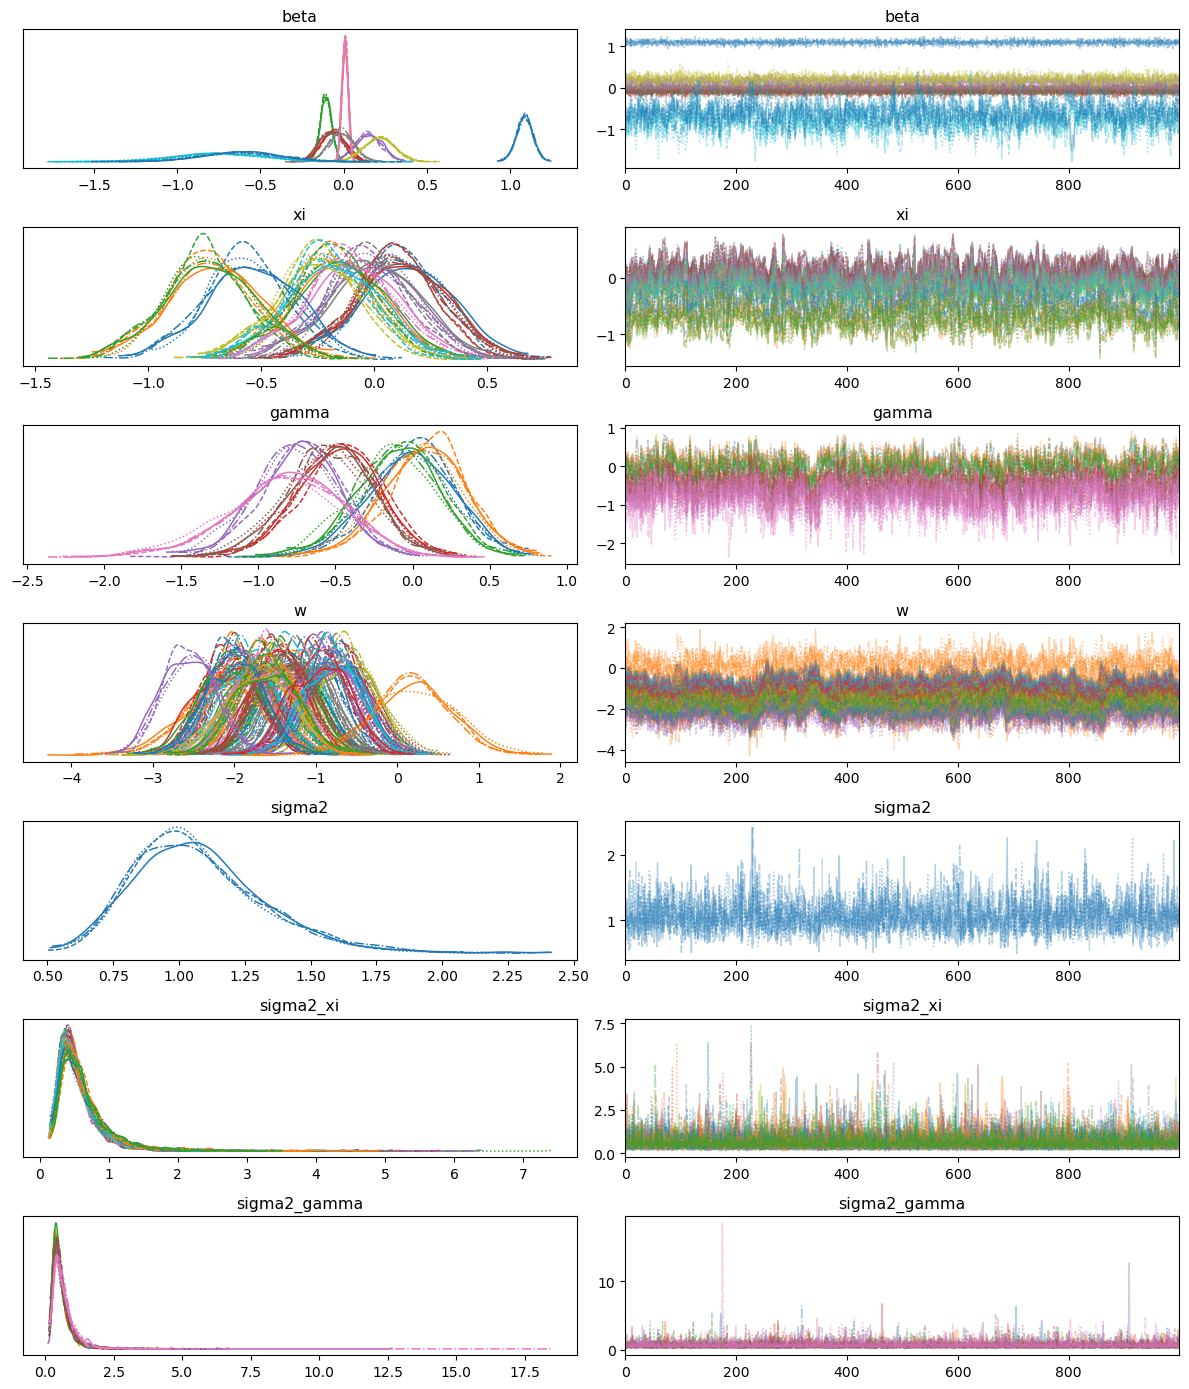

In [44]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [12]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2670.93    76.39
p_waic      123.64        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2671.86    76.45
p_loo      124.57        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2658   99.7%
 (0.5, 0.7]   (ok)          8    0.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [13]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [14]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 131

The total number of outliers in the test set is: 39

The MSE is: 2.010044642857143

The MAE is: 0.6850052521008403

The MAD is: 0.0

The MSE in the test set is: 2.0604203152364273

The MAE in the test set is: 0.7014010507880911

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9655987394957983

The percentage of observations inside the CI of the test is: 0.9658493870402802



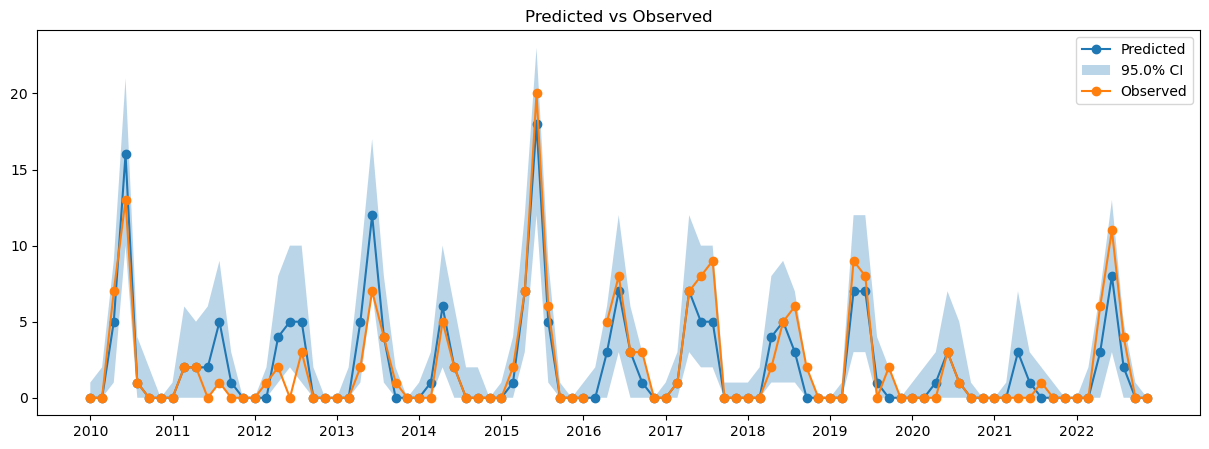

In [15]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [16]:
Models_df.loc['logit',:] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

              WAIC         LOO       MSE       MAE  MAD inside CI MSE test  \
logit -2670.927255 -2671.85768  2.010045  0.685005  0.0  0.965599  2.06042   

       MAE test MAD test inside CI test  
logit  0.701401      0.0       0.965849  


In [17]:
bin_probit = FetchModel('bin_probit').compile()

00:45:06 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_probit.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_probit.exe
00:47:30 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_probit.exe


In [18]:
bin_probit_180 = bin_probit.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_probit_180 = az.from_cmdstanpy(bin_probit_180)

00:47:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:06:42 - cmdstanpy - INFO - CmdStan done processing.
01:06:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: Matrix m is not positive definite (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit.stan', line 52, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [19]:
post_pred = PostPred(posterior_bin_probit_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

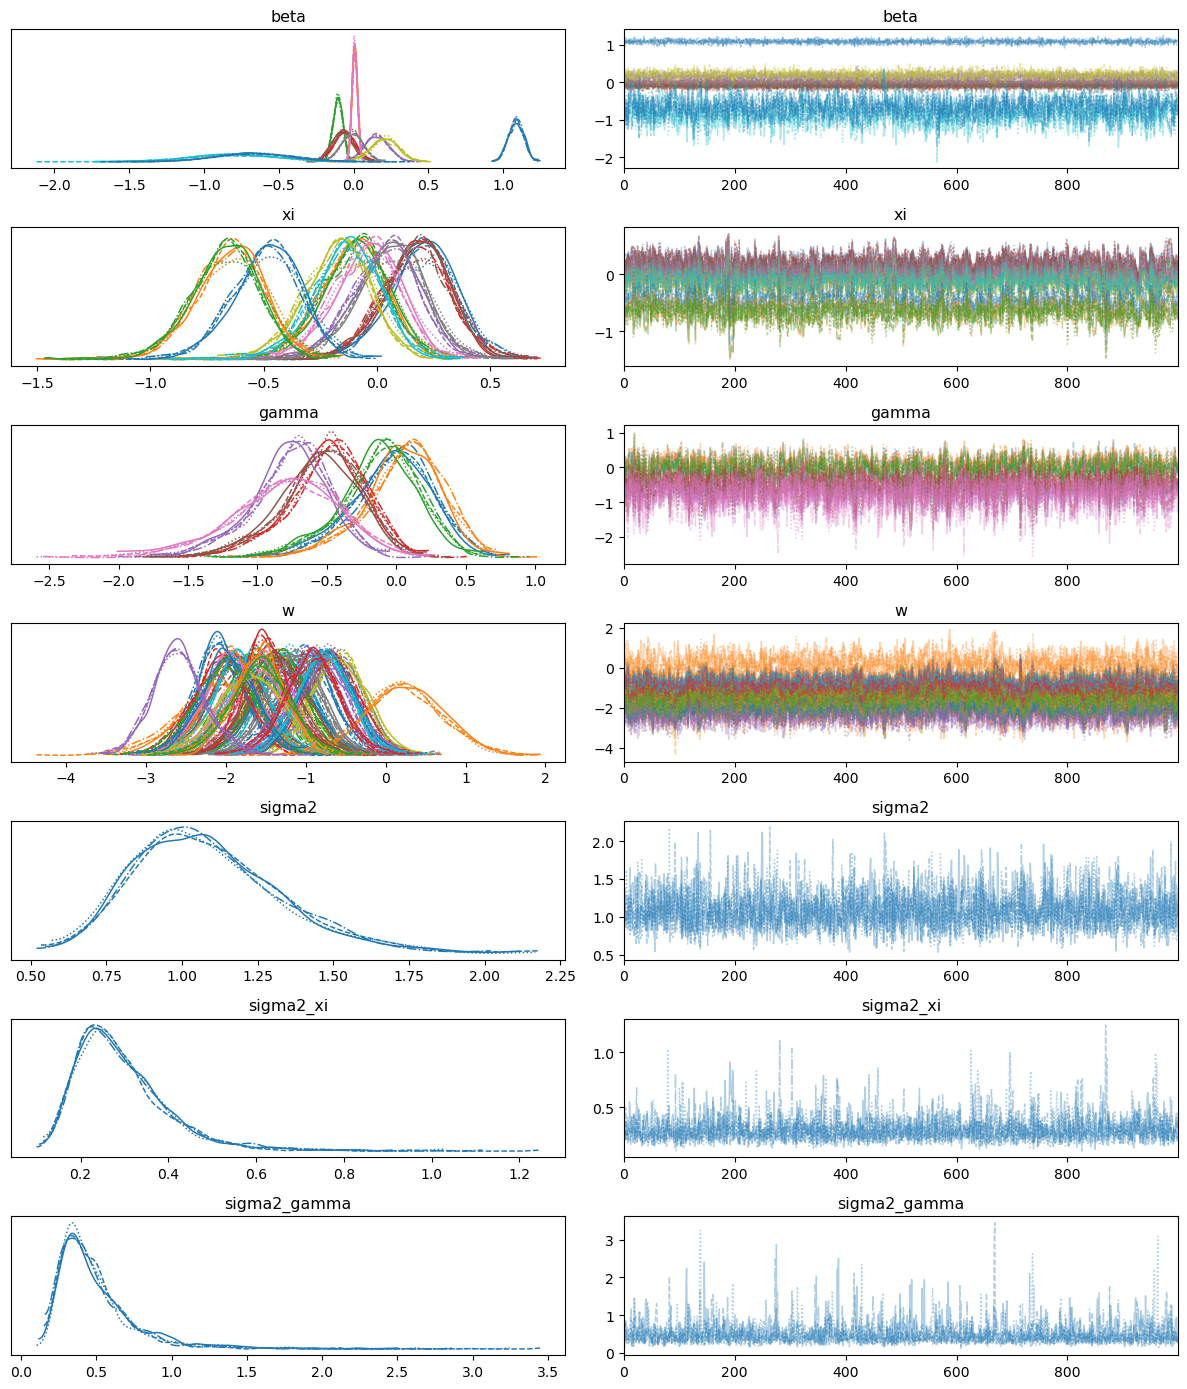

In [20]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [21]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2657.74    78.01
p_waic      124.54        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2658.61    78.08
p_loo      125.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2660   99.8%
 (0.5, 0.7]   (ok)          5    0.2%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [22]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [23]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 130

The total number of outliers in the test set is: 40

The MSE is: 2.003807773109244

The MAE is: 0.6869747899159664

The MAD is: 0.0

The MSE in the test set is: 2.0422504378283715

The MAE in the test set is: 0.7044658493870403

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9658613445378151

The percentage of observations inside the CI of the test is: 0.9649737302977233



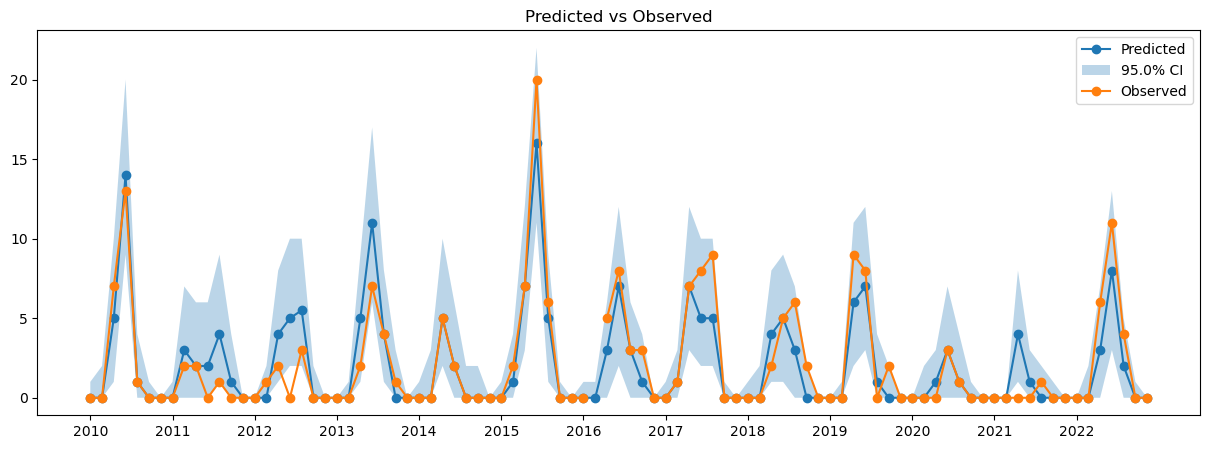

In [24]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [25]:
Models_df.loc['probit', :] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

               WAIC          LOO       MSE       MAE  MAD inside CI MSE test  \
logit  -2670.927255  -2671.85768  2.010045  0.685005  0.0  0.965599  2.06042   
probit -2657.736923 -2658.607891  2.003808  0.686975  0.0  0.965861  2.04225   

        MAE test MAD test inside CI test  
logit   0.701401      0.0       0.965849  
probit  0.704466      0.0       0.964974  


In [26]:
bin_logit_var = FetchModel('bin_logit_var').compile()

01:08:59 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_logit_var.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_logit_var.exe
01:10:32 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_logit_var.exe


In [27]:
bin_logit_var_180 = bin_logit_var.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_logit_var_180 = az.from_cmdstanpy(bin_logit_var_180)

01:10:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:41:45 - cmdstanpy - INFO - CmdStan done processing.


01:41:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_logit_var.stan', line 52, column 2 to column 63)
	Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (i

In [28]:
post_pred = PostPred(posterior_bin_logit_var_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

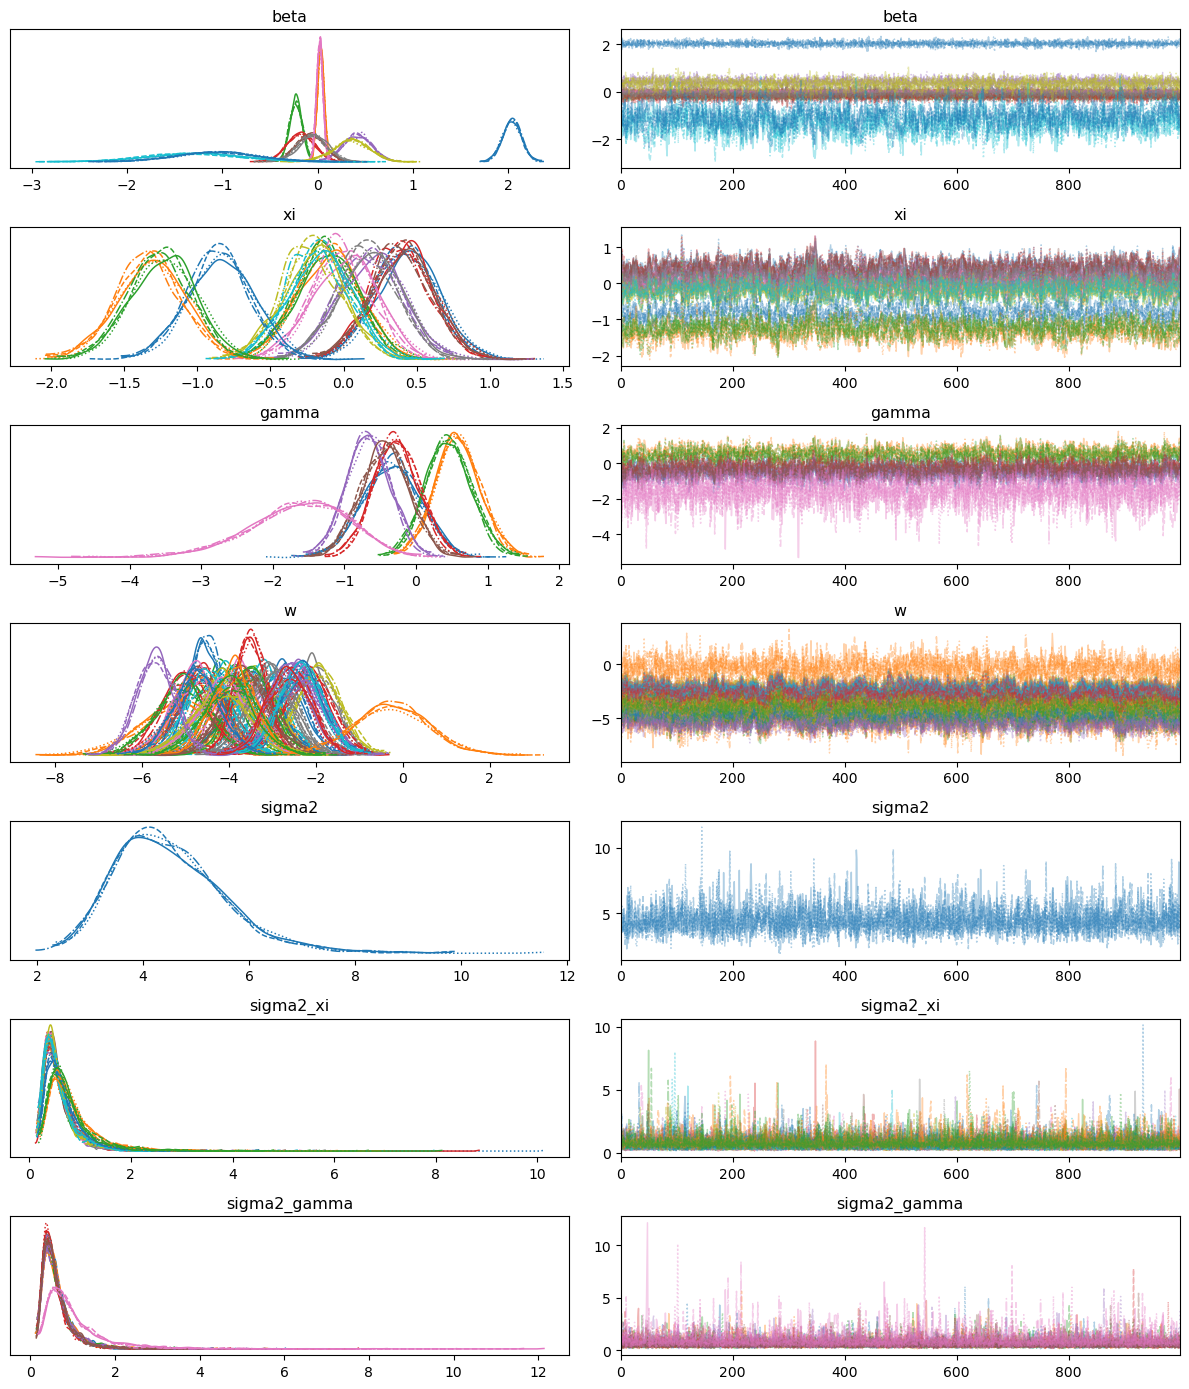

In [29]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [30]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2670.20    76.38
p_waic      123.12        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2671.33    76.48
p_loo      124.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2661   99.8%
 (0.5, 0.7]   (ok)          3    0.1%
   (0.7, 1]   (bad)         2    0.1%
   (1, Inf)   (very bad)    0    0.0%



In [31]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [32]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 130

The total number of outliers in the test set is: 39

The MSE is: 2.0153623949579833

The MAE is: 0.686186974789916

The MAD is: 0.0

The MSE in the test set is: 2.0501313485113837

The MAE in the test set is: 0.696584938704028

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9658613445378151

The percentage of observations inside the CI of the test is: 0.9658493870402802



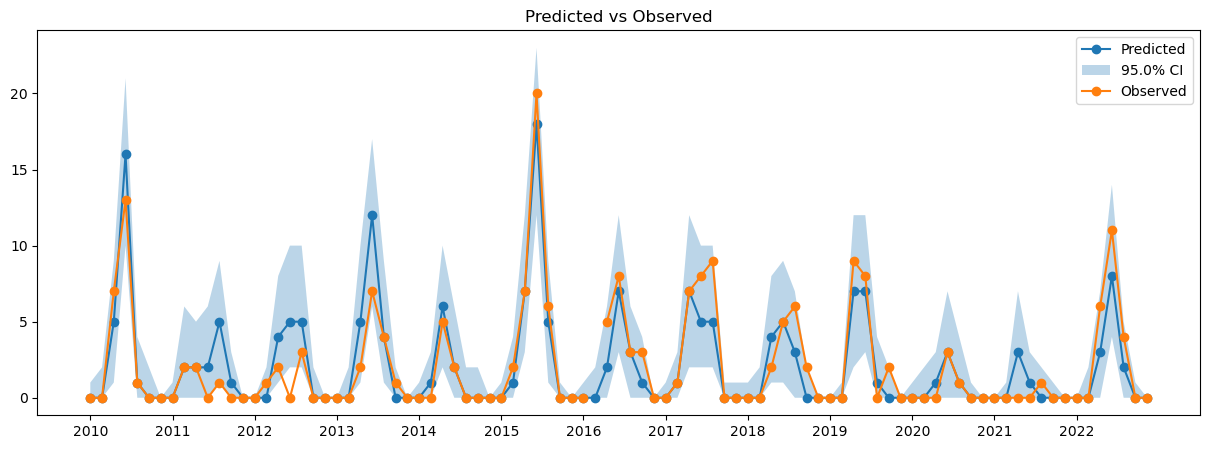

In [33]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [34]:
Models_df.loc['logit var', :] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

                  WAIC          LOO       MSE       MAE  MAD inside CI  \
logit     -2670.927255  -2671.85768  2.010045  0.685005  0.0  0.965599   
probit    -2657.736923 -2658.607891  2.003808  0.686975  0.0  0.965861   
logit var -2670.199079 -2671.326884  2.015362  0.686187  0.0  0.965861   

           MSE test  MAE test MAD test inside CI test  
logit       2.06042  0.701401      0.0       0.965849  
probit      2.04225  0.704466      0.0       0.964974  
logit var  2.050131  0.696585      0.0       0.965849  


In [35]:
bin_probit_var = FetchModel('bin_probit_var').compile()

01:46:06 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_probit_var.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_probit_var.exe
01:49:01 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\stan\bin_probit_var.exe


In [36]:
bin_probit_var_180 = bin_probit_var.sample(data=data_180, chains=4, parallel_chains=4, 
    iter_warmup=1000, iter_sampling=1000)
posterior_bin_probit_var_180 = az.from_cmdstanpy(bin_probit_var_180)

01:49:02 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:21:17 - cmdstanpy - INFO - CmdStan done processing.


02:21:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit_var.stan', line 52, column 2 to column 63)
Exception: cholesky_decompose: A is not symmetric. A[1,2] = inf, but A[2,1] = inf (in 'C:/Users/matte/Desktop/Bayesian_Stat/Bayesian_Project/main/Modello/stan/bin_probit_var.stan', line 52, column 2 to column 63)
Consider re-running with show_console=True if the above output is unclear!


In [37]:
post_pred = PostPred(posterior_bin_probit_var_180, Y['Count_180'], test_train=True, idx_test=idx_test)
Y_data = post_pred.Y
post_pred.posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

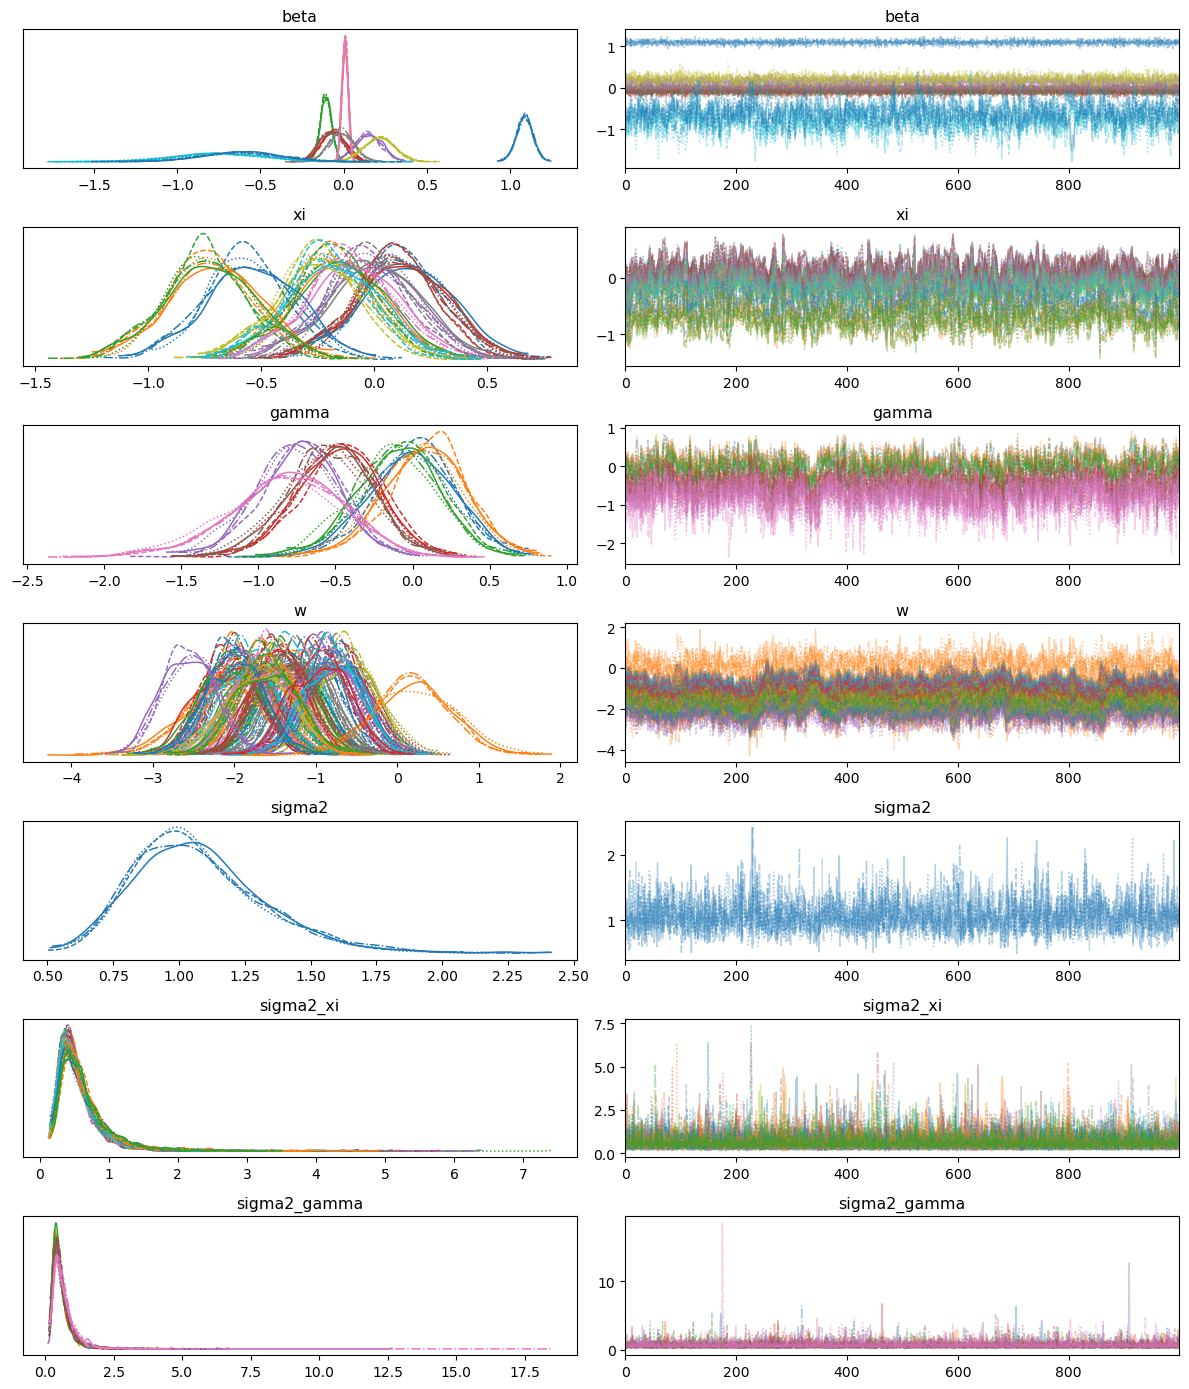

In [38]:
az.plot_trace(post_pred.posterior_az, var_names = ['beta', 'xi', 'gamma', 'w', 'sigma2', 'sigma2_xi', 'sigma2_gamma'])
plt.tight_layout()
plt.show()

In [39]:
waic_out = az.waic(post_pred.posterior_az, var_name='log_lik')
loo_out = az.loo(post_pred.posterior_az, var_name='log_lik')
waic = waic_out.elpd_waic
loo = loo_out.elpd_loo
print(waic_out)
print(loo_out)

c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\matte\anaconda3\envs\stan\Lib\site-packages\arviz\stats\stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -2657.37    78.07
p_waic      124.06        -

There has been a warning during the calculation. Please check the results.
Computed from 4000 posterior samples and 2666 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2658.46    78.17
p_loo      125.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2657   99.7%
 (0.5, 0.7]   (ok)          8    0.3%
   (0.7, 1]   (bad)         1    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [40]:
alpha = 0.05
y_pred, metrics = post_pred.predict(CI=True,
                                       alpha = alpha,
                                       error_metrics = True)

In [41]:
y_obs, residuals, mse, mae, mad, mse_test, mae_test, mad_test, outliers_test, percentage_inside_CI_test, outliers, percentage_inside = metrics.values()
print(f'The total number of outliers is: {len(outliers)}\n')
print(f'The total number of outliers in the test set is: {len(outliers_test)}\n')
print(f'The MSE is: {mse}\n')
print(f'The MAE is: {mae}\n')
print(f'The MAD is: {mad}\n')
print(f'The MSE in the test set is: {mse_test}\n')
print(f'The MAE in the test set is: {mae_test}\n')
print(f'The MAD in the test set is: {mad_test}\n')
print(f'The percentage of observations inside the CI is: {percentage_inside}\n')
print(f'The percentage of observations inside the CI of the test is: {percentage_inside_CI_test}\n')

The total number of outliers is: 134

The total number of outliers in the test set is: 42

The MSE is: 2.003939075630252

The MAE is: 0.688813025210084

The MAD is: 0.0

The MSE in the test set is: 2.0218914185639227

The MAE in the test set is: 0.7014010507880911

The MAD in the test set is: 0.0

The percentage of observations inside the CI is: 0.9648109243697479

The percentage of observations inside the CI of the test is: 0.9632224168126094



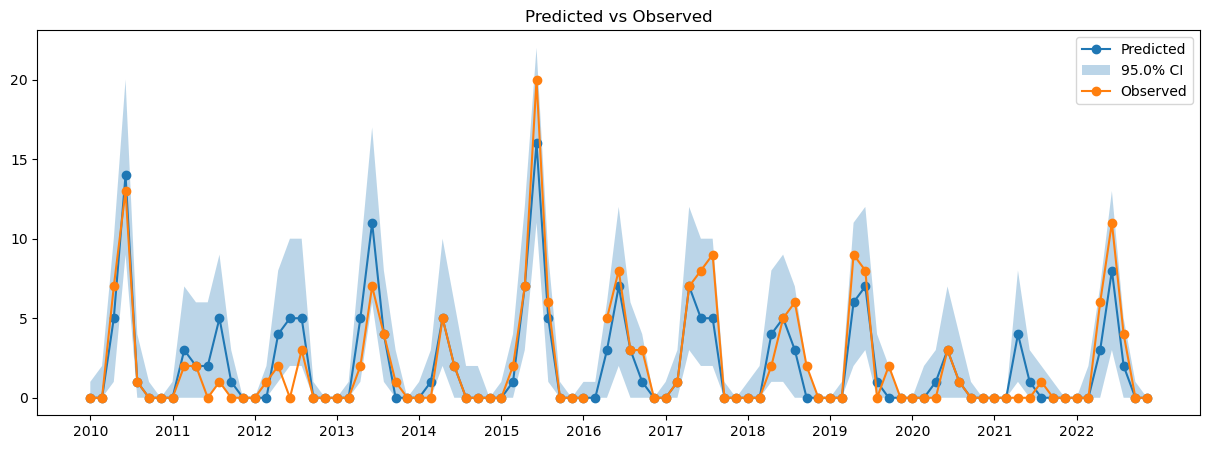

In [42]:
station_num_to_plot = 35 # Change this to plot a different station, -1 to plot manually
if station_num_to_plot != -1:
    xx = np.arange(13*7*(station_num_to_plot-1), 13*7*station_num_to_plot)
else:
    xx = np.arange(1000, 1200) # Change this for the range of the manual choice
plt.figure(figsize=(15, 5))
plt.plot(xx, y_pred.loc[xx, 'pred'], label='Predicted', linestyle='-', marker='o')
plt.fill_between(xx, y_pred.loc[xx, f'{alpha/2}'], y_pred.loc[xx, f'{(1-alpha/2)}'], alpha=0.3, label=f'{(1-alpha)*100}% CI')
plt.plot(xx, Y_data[xx], label='Observed', linestyle='-', marker='o')
plt.xticks(xx[np.arange(0,len(xx),7)], np.arange(2010,2023))
plt.legend()
plt.title('Predicted vs Observed')
plt.show()

In [43]:
Models_df.loc['probit var', :] = [waic, loo, mse, mae, mad, percentage_inside, mse_test, mae_test, mad_test, percentage_inside_CI_test]
print(Models_df)

                   WAIC          LOO       MSE       MAE  MAD inside CI  \
logit      -2670.927255  -2671.85768  2.010045  0.685005  0.0  0.965599   
probit     -2657.736923 -2658.607891  2.003808  0.686975  0.0  0.965861   
logit var  -2670.199079 -2671.326884  2.015362  0.686187  0.0  0.965861   
probit var -2657.370742 -2658.455428  2.003939  0.688813  0.0  0.964811   

            MSE test  MAE test MAD test inside CI test  
logit        2.06042  0.701401      0.0       0.965849  
probit       2.04225  0.704466      0.0       0.964974  
logit var   2.050131  0.696585      0.0       0.965849  
probit var  2.021891  0.701401      0.0       0.963222  
